### Pandas, Pipelines, and Custom Transformers 

An educational video on simplifying complex preprocessing from Julie Michelman's presentation for the 2017 PyData conference. I followed this in order to get a stronger grasp of the Scikit-Learn Pipelines.  

In [20]:
import pandas as pd

In [21]:
df = pd.read_csv('Special_Events_Permits_2016.csv')

In [22]:
df.head()

,application_date,permit_status,permit_type,event_category,event_sub_category,name_of_event,year_month_app,event_start_date,event_end_date,event_location_park,event_location_neighborhood,council_district,precinct,organization,attendance
0,12/09/2015 12:00:00 AM,Complete,Special Event,Athletic,Run/Walk,See Jane Run Women's Half Marathon and 5K,S16JY044,07/10/2016 12:00:00 AM,07/10/2016 12:00:00 AM,Gas Works Park,Multiple Neighborhoods,3,North,See Jane Run,4500.0
1,01/07/2016 12:00:00 AM,Complete,Special Event,Commercial,NaN,Capitol Hill Block Party,S16JY046,07/22/2016 12:00:00 AM,07/24/2016 12:00:00 AM,NaN,Capitol Hill,3,East,Independent Event Solutions,27000.0
2,01/21/2016 12:00:00 AM,Complete,Special Event,Community,NaN,Sounders FC March to the Match (7.09),S16JY074,07/09/2016 12:00:00 AM,07/09/2016 12:00:00 AM,NaN,Pioneer Square,3,West,Seattle Sounders FC,705.0
3,01/21/2016 12:00:00 AM,Complete,Special Event,Community,NaN,Sounders FC March to the Match (7.13),S16JY075,07/13/2016 12:00:00 AM,07/13/2016 12:00:00 AM,NaN,Pioneer Square,3,West,Seattle Sounders FC,705.0
4,01/21/2016 12:00:00 AM,Complete,Special Event,Community,NaN,Sounders FC March to the Match (7.31),S16JY076,07/31/2016 12:00:00 AM,07/31/2016 12:00:00 AM,NaN,Pioneer Square,3,West,Seattle Sounders FC,705.0


What are we going to do?
- outcome -> permit_status (binary)
- features -> everything else! (raw, transformed, combinations, etc.

### Set aside test data 

In [23]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df)

### Define outcome, we will use one feature

In [24]:
import numpy as np
# define the outcome using the Numpy.where function
y_train = np.where(df_train.permit_status == 'Complete', 1, 0)
y_test = np.where(df_test.permit_status == 'Complete', 1, 0)
# We're going to keep it simple and just use attendance as a feature for our model
# In case of any null-values, will fill those in with 0's
X_train = df_train[['attendance']].fillna(value=0)
X_test = df_test[['attendance']].fillna(value=0)


### Create a model object 

In [25]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

### Fit model and predict on training data

Now we fit the model on the training data and we can form predictions from that.


In [26]:
# fit the model to the data so it knows what to predict and what to use in order to do so
model.fit(X_train, y_train)

# this will produce a class prediction (0 or 1)
y_pred_train = model.predict(X_train)

# this will produce a probability prediction
p_pred_train = model.predict_proba(X_train)[:, 1]

### Predict on the test data

We can also predict on the test data, this will help us evaluate how well the model performs.

It's good to start with a baseline: if we come up with the dumbest model we can think of to start off with.
In this case, we take the average of the labels of the training set and repeat that for the length of the training set. Next, we use the predict_proba function to get the outcomes for the test data.

So now we have basically two things:
- predicted values (which are all the mean of the y of the training set)
- the predicted probabilities of the y_test using a predictive model that takes X_test as an input

In [27]:
# dumb model that uses only the means
p_baseline_test = [y_train.mean()]*len(y_test)

# smarter model to predict probabilities
p_pred_test = model.predict_proba(X_test)[:,1]

### Measure performance on test data

We use auc scores to evaluate the performance of both models.

In [28]:
from sklearn.metrics import roc_auc_score

# evaluate baseline model by comparing the y_test values and the baseline_test outcomes
auc_baseline = roc_auc_score(y_test, p_baseline_test)
print(auc_baseline) 
# evaluate the smarter model by comparing the y_test with the p_pred_test outcomes
auc_test = roc_auc_score(y_test, p_pred_test)
print(auc_test) 

0.5
0.4504065040650407


# Transformers & Estimators

***transformer*** (for data preparation)

Transformers are for data preparation. Transformers transform input data (x) in some ways.
- has a fit() method: what this does is it takes the training data and finds all the parameters that the transformer estimator needs.
- has a **transform(X, y)** method: applies the transformation to the training data or test data.

***Estimator*** (for modeling)

Estimator predicts a new value (or values) (y) by using the input data (X). 
- Also has a fit() method because it needs to learn the data
- The estimator has the **predict(X)** method which should output the predicted y value from the given X.

fit() does not return any value, it simply stores the learnt data inside the object.


 ****For example****

You use the **StandardScaler** transformer in order to standardize features. 
- fit(): find mean, standard deviation of each feature.
- transform(): subtract mean, divide by standard deviation

Then, you use the **LogisticRegression** estimator for predictions. 
- fit(): find coefficients in logistic regression formula.
- predict(): plug into formula, get predicted class from predicted probability.


### Multiple transformers

Sometimes you want to go through multiple transformations in the course of feature engeneering. Code can get a bit messy if we work with multiple transformers.

Luckily, Scikit-Learn has ***Pipelines***, which work as meta-transformers which take your whole list of transformers and apply them in a row.

In [29]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (PolynomialFeatures, StandardScaler)
from sklearn.pipeline import Pipeline

Imputer = SimpleImputer
pipeline = Pipeline([
    ('imputer', Imputer()),
    ('quadratic', PolynomialFeatures()),
    ('standardizer', StandardScaler())
])

You could easily write something like this to get the pipeline going:

- X_train = pipeline.fit_transform(X_train_raw)
- X_test = pipeline.transform(X_test_raw)

### Transformers in Parrallel

Sometimes you want to try out more than one transformation. For example, should we impute with a mean or median or most_frequent value? Which one works best?

Let our machine learning algorithm decide for us!

FeatureUnion concatenates results of multiple transformer objects. This estimator applies a list of transformer objects in parallel to the input data, then concatenates the results. This is useful to combine several feature extraction mechanisms into a single transformer.

In [30]:
from sklearn.pipeline import FeatureUnion

feature_union = FeatureUnion ([
    ('fill_avg', Imputer(strategy='mean')),
    ('fill_mid', Imputer(strategy='median')),
    ('fill_freq', Imputer(strategy='most_frequent'))
])

You could write this easily:
- X_train = feature_union.fit_transform(X_train_raw)
- X_test = feature_union.transform(X_test_raw)

### Back to the dataset

let's take a look at the event_location_park column

In [31]:
df_train.event_location_park.value_counts(dropna=False).head()

NaN                366
Gas Works Park       7
Magnuson Park        5
Lake Union Park      2
Occidental Park      2
Name: event_location_park, dtype: int64

Over 350 of them are NaNs.

#### Estimated attendance: a few missing, right-skewed

Another interesting column is the attendance. 

In [32]:
# check out whether there are any missing values easily.
X_train.attendance.isnull().sum()
# check out if there is any infinity present.
X_train.max()

attendance    251000.0
dtype: float64

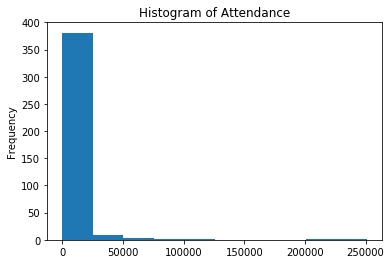

In [33]:
x = X_train.attendance
x.plot(kind='hist', title='Histogram of Attendance')

The danger here lies around the 200,000 to 250,000 events. These are sort of outliers that can pull your ML algorithm towards it. In other words, the skewness of the data may be problematic for the ML.

In [34]:
np_log = np.log(x) 
np_log.max()


# np_log.plot(kind='hist')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


12.43320821811392

In [35]:
np_log.max()

12.43320821811392

In [36]:
np.isfinite(np_log)

116    True
15     True
276    True
460    True
486    True
       ... 
299    True
221    True
478    True
260    True
148    True
Name: attendance, Length: 396, dtype: bool

### Function transformer

When you look for a certain transformer and can't find it, Scikit-Learn provides a generic transformer tool. All you need to do is give it a function and it will be turned into a transformer.

All you need to do is create a function transform object, pass in a function (in this case log1p which takes log and prevents infinite zeros from happening). Next, you simply call that function.

In [37]:
from sklearn.preprocessing import FunctionTransformer
logger = FunctionTransformer(np.log1p)
X_log = logger.transform(X)

NameError: name 'X' is not defined

***Alternatively***, you could write your own custom transformer. TransforMixin will do stuff automatically. The fit method doesn't need to do anything because there aren't any parameters that it needs to know from the training data. After all, you just want to transform stuff but nonetheless a fit function needs to be included because otherwise it's not accepted by TransformerMixin.

In [38]:
from sklearn.base import TransformerMixin

class Log1pTransformer(TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xlog = np.log1p(X)
        return Xlog

### Dealing with the parks in our datasets

The idea is one hot encoding (dummy encoding). The DictVectorizer that comes with ScikitLearn helps with this but it's not perfect yet.

The ***DictVectorizer*** transforms lists of feature-value mappings to vectors. I.e. it turns feature names into feature values in NumPy arrays for use with estimators.

In [39]:
from sklearn.feature_extraction import DictVectorizer

class DummyTransformer(TransformerMixin):
    
    def __init__(self):
        # create a field to hold that internal transformer 
        self.dv = None 
    
    def fit(self, X, y=None):
        
        # X is a string input. We turn each row into a record. 
        # This is a mapping from the column name to the column value (0, 1)
        # This is the format the dictvectorizer wants
        Xdict = X.to_dict('records')
        # apply the DictVectorizer method
        self.dv = DictVectorizer(sparse=False)
        # Fit the DictVectorizer method
        self.dv.fit(Xdict)
        # Return itself, which is equal to self.dv
        return self
    
    def transform(self, X):
        # Turn the dataset into records
        Xdict = X.to_dict('records')
        # call the transform on the internal transformer
        Xt = self.dv.transform(Xdict)
        # Grab the feature names that it produces
        cols = self.dv.get_feature_names()
        # pull the index and throw it all back on and turn it into a dataframe
        Xdum = pd.DataFrame(Xt, index=X.index, columns=cols)
        return Xdum


### Pandas versus Scikit-Learn

Pandas DataFrames...
- support many datatypes
- allow missing data
- labeled rows and columns

Scikit-Learn Models...
- Expect all numeric features
- Can't handle nulls (usually)
- Cast to NumPy arrays

We want to stay in Pandas land. We can do so as long as possible by having custom transformers that return DataFrames.

In [40]:
class DFFeatureUnion(TransformerMixin):
    # FeatureUnion but for pandas DataFrames

    def __init__(self, transformer_list):
        self.transformer_list = transformer_list

    def fit(self, X, y=None):
        for (name, t) in self.transformer_list:
            t.fit(X, y)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xts = [t.transform(X) for _, t in self.transformer_list]
        Xunion = reduce(lambda X1, X2: pd.merge(X1, X2, left_index=True, right_index=True), Xts)
        return Xunion

In [41]:
class ZeroFillTransformer(TransformerMixin):

    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xz = X.fillna(value=0)
        return Xz

In [42]:
class ColumnExtractor(TransformerMixin):
    # give it a list of columns we want
    def __init__ (self, cols):
        
        self.cols = cols
    
    # doesn't do anything
    def fit(self, X, y=None):
        return self
    
    # takes a certain column X and slices to those columns
    def transform(self, X):
        Xcols = X[self.cols]
        return Xcols

In [43]:
class DFStandardScaler(TransformerMixin):
    # StandardScaler but for pandas DataFrames

    def __init__(self):
        self.ss = None
        self.mean_ = None
        self.scale_ = None

    def fit(self, X, y=None):
        self.ss = StandardScaler()
        self.ss.fit(X)
        self.mean_ = pd.Series(self.ss.mean_, index=X.columns)
        self.scale_ = pd.Series(self.ss.scale_, index=X.columns)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xss = self.ss.transform(X)
        Xscaled = pd.DataFrame(Xss, index=X.index, columns=X.columns)
        return Xscaled
    

### Putting it all together - Feature Engineering

List the categorical and numerical features

In [44]:
CAT_FEATS = [
    'permit_type', 'event_category', 'event_sub_category', 'event_location_park', 'event_location_neighborhood'
]
NUM_FEATS = ['attendance']

Create a pipeline and include our custom FeatureUnion to simultaneously handle categoricals and numericals.

In [45]:
pipeline = Pipeline([
    ('features', DFFeatureUnion([
        ('categoricals', Pipeline([
            ('extract', ColumnExtractor(CAT_FEATS)),
            ('dummy', DummyTransformer())
        ])),
        ('numerics', Pipeline([
            ('extract', ColumnExtractor(NUM_FEATS)),
            ('zero_fill', ZeroFillTransformer()),
            ('log', Log1pTransformer())
        ]))
    ])),
    ('scale', DFStandardScaler())
])

### Apply the Pipeline

In [46]:
from functools import reduce
X_train = pipeline.fit_transform(df_train)
X_test = pipeline.transform(df_test)

### Fit model

In [47]:
model = LogisticRegression()
model.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [48]:
p_pred_test = model.predict_proba(X_test)[:, 1]

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### Measure performance on test data set (first model had AUC = 0.57)

In [49]:
auc_test = roc_auc_score(y_test, p_pred_test) #0.71